In [ ]:
# !pip install jcopdl

In [ ]:
# !pip install luwiji

In [ ]:
# !pip install gdown

In [ ]:
# !gdown https://drive.google.com/file/d/1RmJAcVzvJknwO_MHxTRje3IOSCnMsUkJ/view?usp=sharing 

In [ ]:
# !unzip /content/data.zip

In [1]:
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.9', '1.1.8')

In [208]:
import numpy as np
import matplotlib.pyplot as plt

In [209]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [210]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [234]:
bs = 128
crop_size = 100

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(110),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [235]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 224, 224])

In [236]:
label2cat = train_set.classes
label2cat

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

# Arsiketur & Config

In [237]:
from jcopdl.layers import linear_block, conv_block

In [238]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
#             conv_block(3, 8),
#             conv_block(8, 16),
#             conv_block(16, 32),
#             conv_block(32, 64),
#             conv_block(64, 128),
            nn.Conv2d(3, 10, 3),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(10, 20, 3),
            nn.ReLU(),
            nn.Conv2d(20, 20, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(9680, 512, dropout=0.2),
            linear_block(512, 4, activation="lsoftmax")
        )
        
    def forward(self, x):
        return self.fc(self.conv(x))

In [239]:
config = set_config({
    "output_size" : len(label2cat),
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Training Preparation => MCOC

In [240]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training 

In [241]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.1790 | Test_cost  = 0.9335 | Train_score = 0.4667 | Test_score = 0.6822 |


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.7066 | Test_cost  = 0.7147 | Train_score = 0.7332 | Test_score = 0.7395 |


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5156 | Test_cost  = 0.6798 | Train_score = 0.7938 | Test_score = 0.7515 |


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4544 | Test_cost  = 0.6300 | Train_score = 0.8081 | Test_score = 0.7742 |


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4096 | Test_cost  = 0.5874 | Train_score = 0.8204 | Test_score = 0.7897 |


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.3850 | Test_cost  = 0.5365 | Train_score = 0.8278 | Test_score = 0.7933 |


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3907 | Test_cost  = 0.5121 | Train_score = 0.8296 | Test_score = 0.7981 |


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3694 | Test_cost  = 0.5058 | Train_score = 0.8326 | Test_score = 0.7981 |
==> EarlyStop patience =  1 | Best test_score: 0.7981


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3462 | Test_cost  = 0.5591 | Train_score = 0.8448 | Test_score = 0.8065 |


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3377 | Test_cost  = 0.5178 | Train_score = 0.8580 | Test_score = 0.8172 |


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3105 | Test_cost  = 0.5419 | Train_score = 0.8669 | Test_score = 0.8053 |
==> EarlyStop patience =  1 | Best test_score: 0.8172


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3316 | Test_cost  = 0.4747 | Train_score = 0.8621 | Test_score = 0.8172 |
==> EarlyStop patience =  2 | Best test_score: 0.8172


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3050 | Test_cost  = 0.4495 | Train_score = 0.8732 | Test_score = 0.8136 |
==> EarlyStop patience =  3 | Best test_score: 0.8172


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2944 | Test_cost  = 0.5382 | Train_score = 0.8818 | Test_score = 0.7933 |
==> EarlyStop patience =  4 | Best test_score: 0.8172


Train:   0%|          | 0/27 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.2736 | Test_cost  = 0.4686 | Train_score = 0.8890 | Test_score = 0.8112 |
==> EarlyStop patience =  5 | Best test_score: 0.8172
==> Execute Early Stopping at epoch: 15 | Best test_score: 0.8172
==> Best model is saved at model


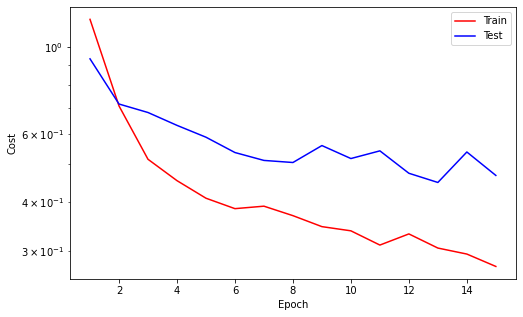

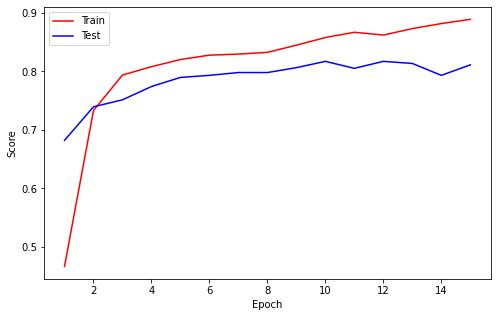

In [242]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [258]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [259]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
    acc = (target == preds).to(torch.float32).mean()
acc, preds

(tensor(0.8359, device='cuda:0'),
 tensor([1, 0, 1, 3, 0, 0, 1, 3, 3, 2, 0, 0, 0, 0, 3, 1, 0, 3, 1, 0, 3, 1, 3, 0,
         3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 2, 0, 3, 3, 3, 0, 1, 3, 1, 0, 0, 3, 3, 0,
         2, 2, 0, 2, 3, 1, 1, 3, 3, 2, 0, 3, 1, 2, 3, 1, 1, 3, 2, 3, 3, 1, 0, 3,
         1, 3, 0, 0, 3, 1, 3, 3, 1, 1, 1, 2, 2, 3, 0, 3, 0, 0, 0, 1, 2, 1, 3, 0,
         3, 0, 2, 3, 0, 3, 3, 0, 0, 0, 0, 1, 3, 0, 2, 2, 2, 0, 0, 2, 3, 0, 2, 1,
         2, 3, 3, 3, 0, 3, 3, 0], device='cuda:0'))

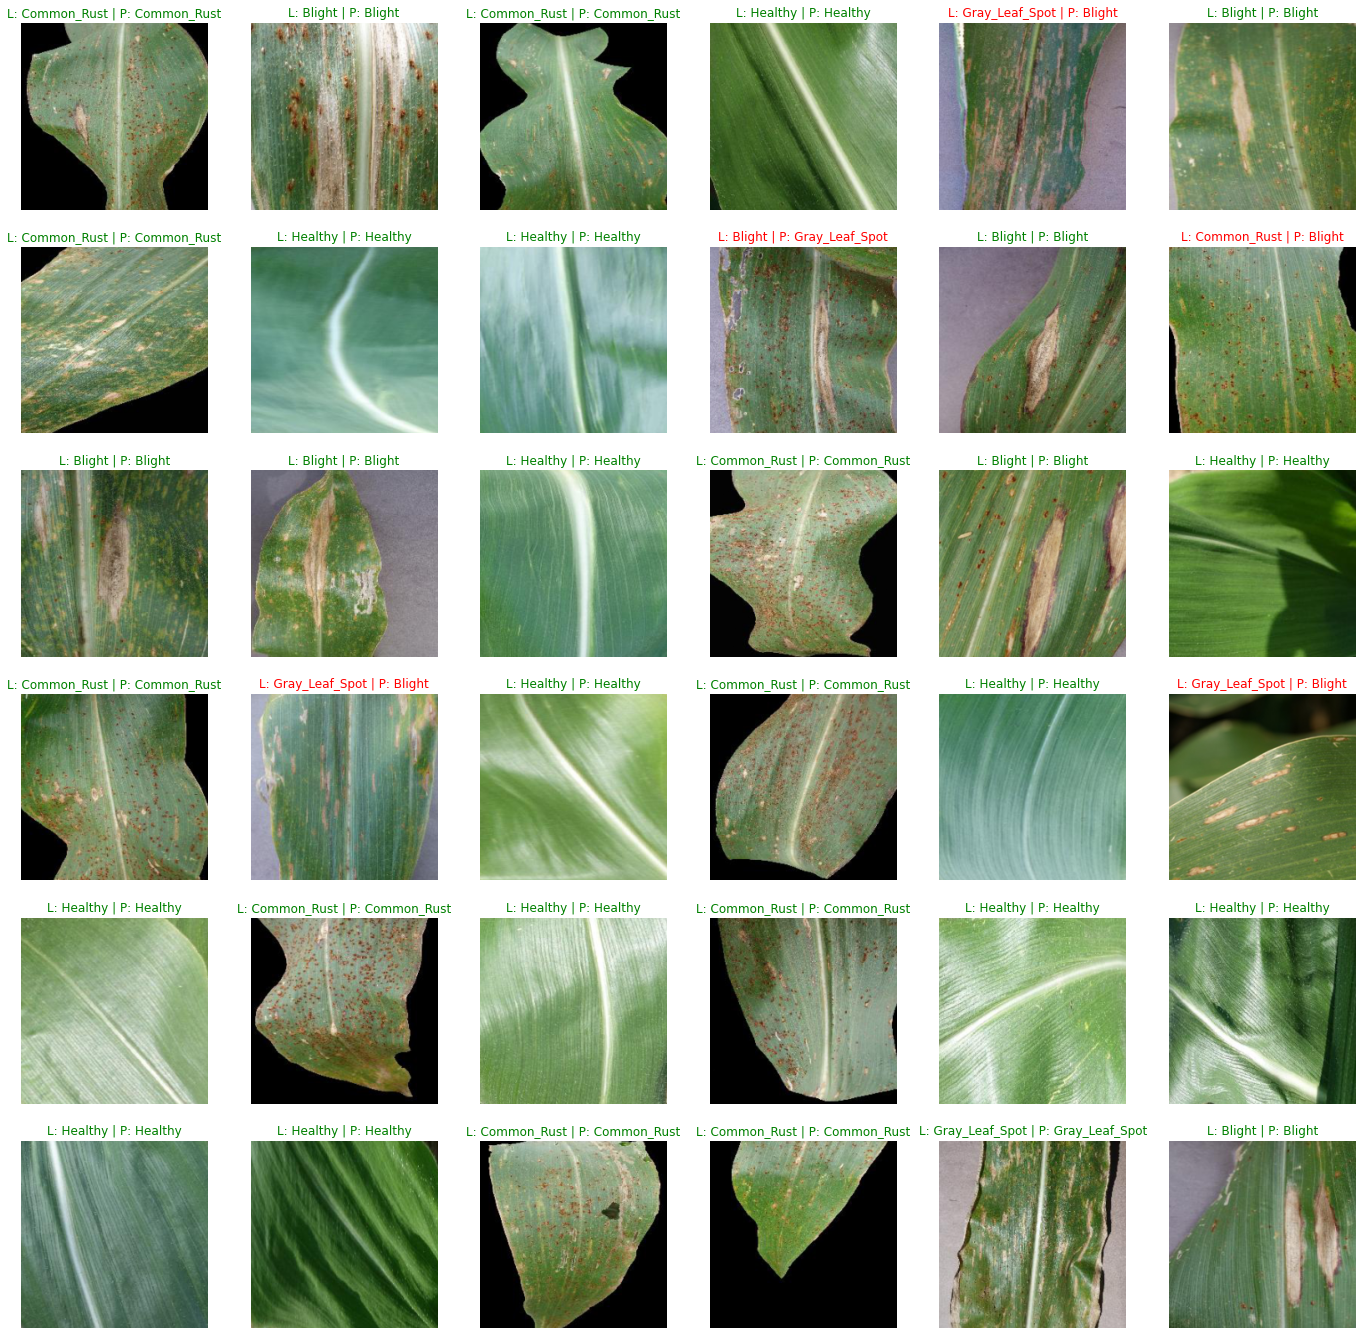

In [260]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');

In [ ]:
# !zip -r model.zip /content/model

In [3]:
torch.cuda.is_available()

False